# Sarcasm Detection Pipeline — Part 1: The Baseline Linguistic Model
The primary challenge in sarcasm detection is that the "literal" meaning of a sentence often masks the "intended" meaning. To build a robust multi-task learning system, we first need a strong Baseline Model that understands the linguistic patterns of the dataset. This model serves as the control group to measure the performance lift gained from adding emotional and personality features later in the fusion stage.


Dataset used:
https://www.kaggle.com/datasets/danofer/sarcasm



## Imports and Data Loading

In [1]:

import kagglehub
danofer_sarcasm_path = kagglehub.dataset_download('danofer/sarcasm')

print('Data source import complete.')


/Users/atharvapatil/Documents/refined notebooks for resume/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import os
from os import path
sns.set()
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import datetime as dt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import calendar
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import time
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from keras.preprocessing import sequence
from tensorflow.keras.preprocessing import text
from keras.layers import Conv1D, Flatten,MaxPooling1D
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import auc


In [3]:
file_path = os.path.join(danofer_sarcasm_path, 'train-balanced-sarcasm.csv')

In [4]:
sarcasm_df = pd.read_csv(file_path)
sarcasm_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## Data Pre-Processing and EDA
Implementing lowercasing and regex to strip non-alphanumeric characters.

In supervised learning for sarcasm detection, an imbalanced dataset can lead to high accuracy but poor F1-scores, as the model may simply learn to predict the majority class. By visualizing the distribution of the label column, we confirm that the dataset is perfectly balanced (50% Sarcastic, 50% Non-Sarcastic). This ensures that our baseline metrics are a true reflection of the model's linguistic understanding rather than a result of frequency bias.

In [5]:
sarcasm_df.dropna(subset=['comment'], inplace=True)
sarcasm_df['comment'] = sarcasm_df['comment'].str.lower()
sarcasm_df['comment'] = sarcasm_df['comment'].str.replace('[^\w\s]','')

<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
/var/folders/xt/1z5mn7yd6v328jlx58hm89y40000gn/T/ipykernel_11765/1669860045.py:3: SyntaxWarning: invalid escape sequence '\w'
  sarcasm_df['comment'] = sarcasm_df['comment'].str.replace('[^\w\s]','')


In [6]:
sarcasm_df.created_utc = pd.to_datetime(sarcasm_df.created_utc)
sarcasm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1010771 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   label           1010771 non-null  int64         
 1   comment         1010771 non-null  object        
 2   author          1010771 non-null  object        
 3   subreddit       1010771 non-null  object        
 4   score           1010771 non-null  int64         
 5   ups             1010771 non-null  int64         
 6   downs           1010771 non-null  int64         
 7   date            1010771 non-null  object        
 8   created_utc     1010771 non-null  datetime64[ns]
 9   parent_comment  1010771 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 84.8+ MB


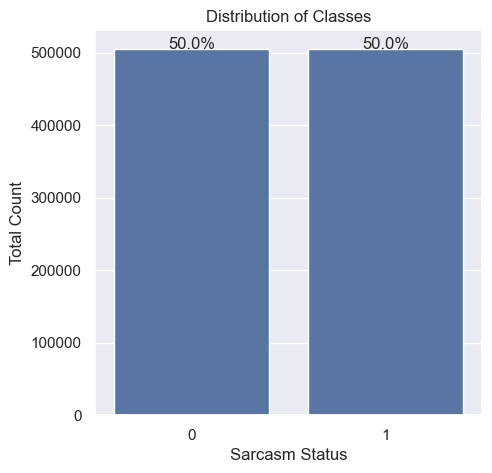

In [7]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x='label',  data= sarcasm_df)
ax.set(title = "Distribution of Classes", xlabel="Sarcasm Status", ylabel = "Total Count")
total = float(len(sarcasm_df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format((height/total)*100),
            ha="center")
plt.show()

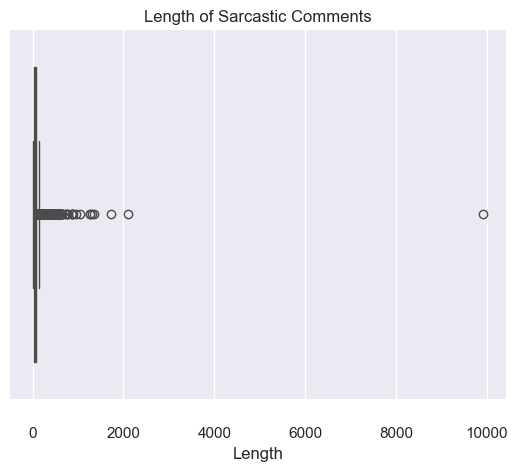

In [8]:
# distribution of the length of sarcastic comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df['label'] == 1, 'comment'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

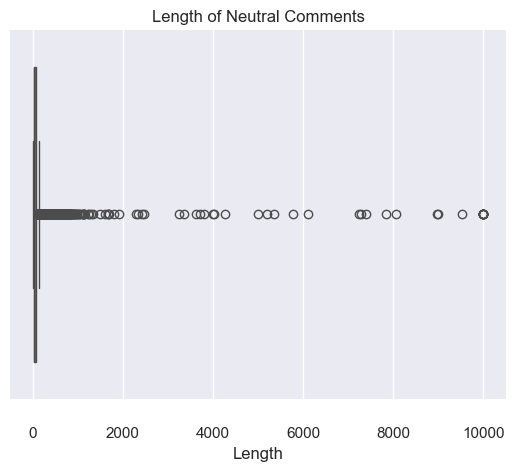

In [9]:
# distribution of the length of neutral comments
sns.boxplot(x= sarcasm_df.loc[sarcasm_df['label'] == 0, 'comment'].str.len()).set(title = 'Length of Neutral Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

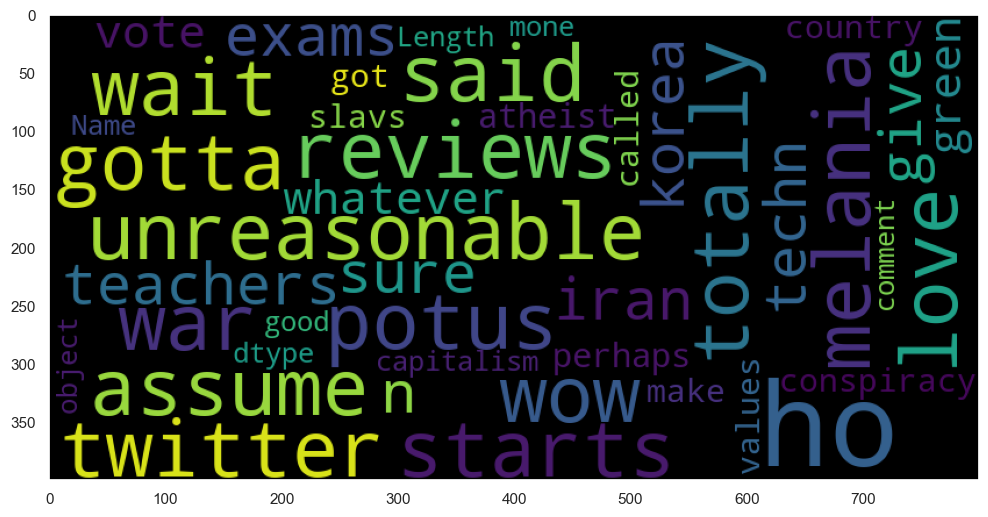

In [10]:
# visualizing word cloud
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100,
                random_state = 17, width=800, height=400)

plt.figure(figsize=(12, 12))
wordcloud.generate(str(sarcasm_df.loc[sarcasm_df['label'] == 1, 'comment']))
plt.grid()
plt.imshow(wordcloud);

In [11]:
# converting the scores into numpy array
sarcasm_score = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['score'])
neutral_score = np.array(sarcasm_df.loc[sarcasm_df['label'] == 0]['score'])

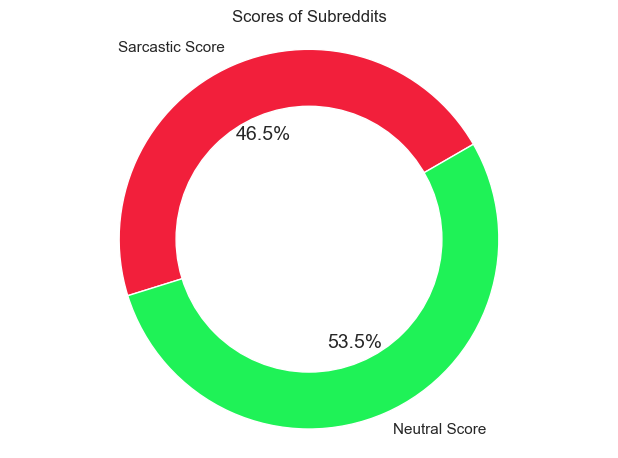

In [12]:

labels = ['Sarcastic Score', 'Neutral Score']
sizes = [3235069, 3725113]

colors = ['#F21F3B', '#1FF257']

plt.rcParams.update({'font.size': 14})
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=30)
ax1.set_title("Scores of Subreddits")

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
plt.tight_layout()
plt.show()

In [13]:
sarcasm_comm_len = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['comment'].str.len())
parent_comm_len = np.array(sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len())
ratio_len = np.array((sarcasm_df.loc[sarcasm_df['label'] == 1]['comment'].str.len())/(sarcasm_df.loc[sarcasm_df['label'] == 1]['parent_comment'].str.len()))

In [14]:
dataset = pd.DataFrame({'Comment Length': sarcasm_comm_len, 'Parent Comment Length': parent_comm_len, 'Ratio Length': ratio_len}, columns=['Comment Length', 'Parent Comment Length', 'Ratio Length'])

## Text Length Analysis
Beyond simple label counts, we analyze the distribution of comment lengths. Sarcastic remarks often differ in length and punctuation density compared to serious comments. Visualizing these distributions helps us justify the use of N-grams in our vectorizer; if sarcastic comments are consistently shorter or use specific word pairings, the model will capture these as critical linguistic features.

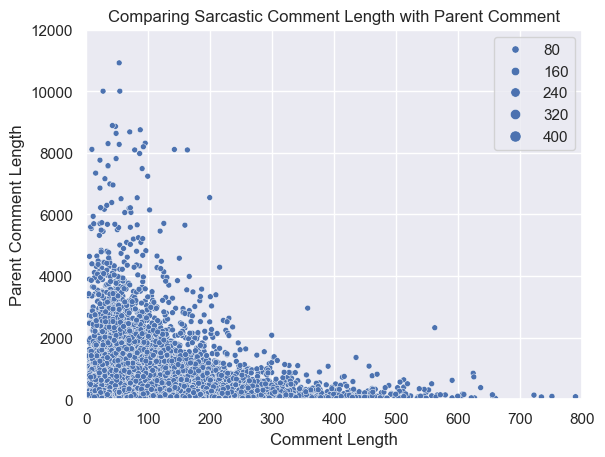

In [15]:
# comparing the length of the post comment and the length of sarcastic comments on that post or comment
ax = plt.axes()
sns.scatterplot(data=dataset, x="Comment Length", y="Parent Comment Length",  size=ratio_len)
ax.set_title("Comparing Sarcastic Comment Length with Parent Comment")

plt.ylim(0, 12000)
plt.xlim(0, 800)
plt.show()

### Subreddit Analysis

In [16]:
# getting the top 5 popular subreddits
sarcasm_df['subreddit'].value_counts()[:5]

subreddit
AskReddit          65674
politics           39493
worldnews          26375
leagueoflegends    21034
pcmasterrace       18987
Name: count, dtype: int64

In [17]:
top_reddits =['AskReddit', 'politics', 'worldnews', 'leagueoflegends', 'pcmasterrace']

In [18]:

subreddit = pd.DataFrame()
subreddit['subreddit'] = top_reddits
subreddit['sarcastic'] = np.nan
subreddit['natural'] = np.nan
subreddit['total'] = np.nan

In [20]:
# calculating the count of Sarcastic and Natural comments for the top 5 subreddits
for i in range(len(subreddit)):

    sub_name = subreddit.subreddit.iloc[i]
    temp = sarcasm_df.loc[sarcasm_df['subreddit'] == sub_name]


    total_len = len(temp)
    count_sarcastic = temp['label'].sum() # label 1 = sarcastic

    row_idx = subreddit.index[i]
    subreddit.at[row_idx, 'sarcastic'] = count_sarcastic
    subreddit.at[row_idx, 'natural'] = total_len - count_sarcastic
    subreddit.at[row_idx, 'total'] = total_len

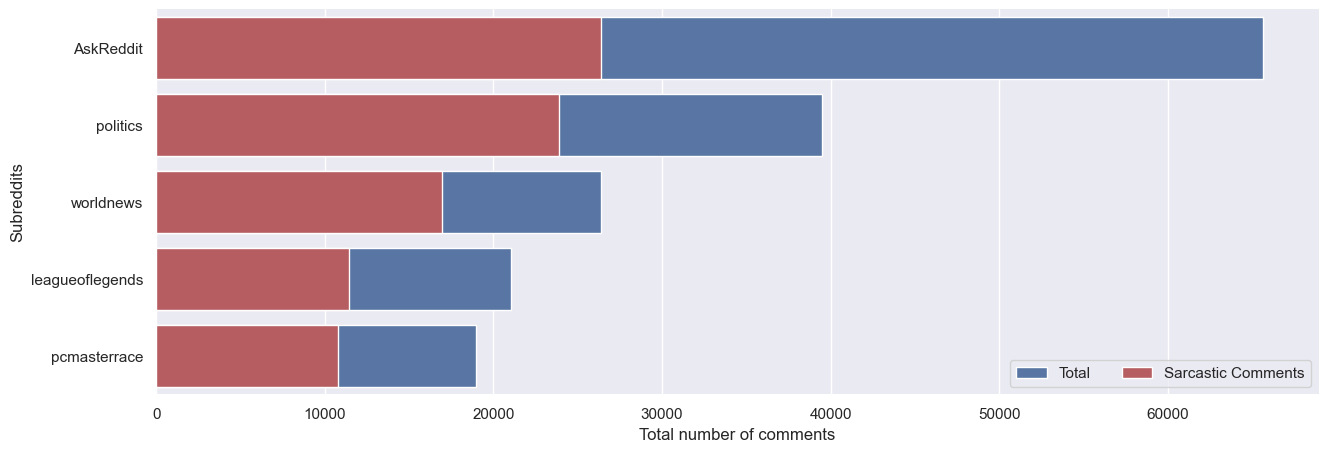

In [21]:

f, ax = plt.subplots(figsize=(15, 5))

sns.barplot(x="total", y="subreddit", data=subreddit,
            label="Total", color="b")

sns.barplot(x="sarcastic", y="subreddit", data=subreddit,
            label="Sarcastic Comments", color="r")
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set( ylabel="Subreddits",
       xlabel="Total number of comments")
sns.despine(left=True, bottom=True)

### Analyzing comments by the day


In [23]:

sarcasm_df['created_utc'] = pd.to_datetime(sarcasm_df['created_utc'], format = '%d/%m/%Y %H:%M:%S')
sarcasm_df['Day of Week'] = sarcasm_df['created_utc'].dt.day_name()

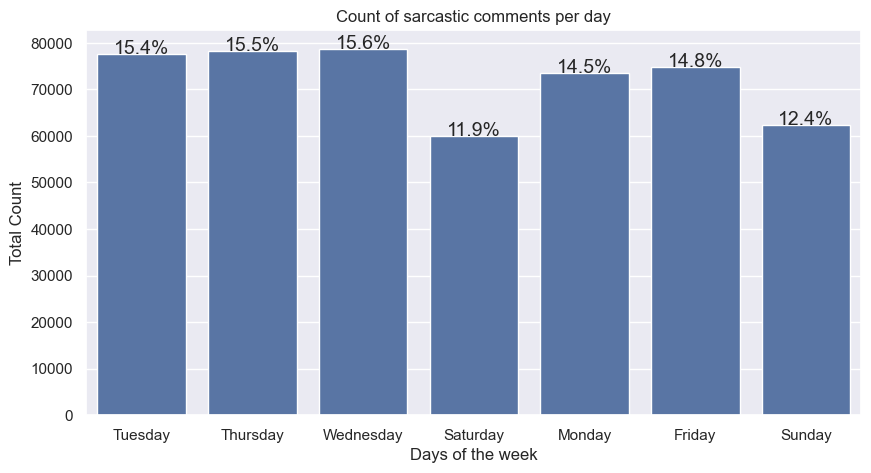

In [24]:

plt.figure(figsize=(10,5))
ax = sns.countplot(x='Day of Week',  data= sarcasm_df.loc[sarcasm_df['label']==1])
ax.set(title = "Count of sarcastic comments per day", xlabel="Days of the week", ylabel = "Total Count")
total = float(len(sarcasm_df ))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 7,
            '{:1.1f}%'.format((height/total)*100*2),
            ha="center")
plt.show()

## Feature Extraction: Transforming Text to Vectors
To feed social media text into a Deep Learning architecture, we must transform strings into uniform numerical tensors. This process involves two critical steps:\

Tokenization: Mapping the top $1000$ most frequent words to unique integer indices, focusing on the most statistically significant linguistic markers.\
Sequence Padding: Normalizing all input lengths to $1000$ tokens. This ensures that the model receives consistent spatial dimensions, allowing the convolutional kernels to scan the text uniformly.


In [32]:

vocab_size = 1000
maxlen = 1000
embedding_dims = 50
filters = 32
kernel_size = 3
hidden_dims = 250
epochs = 10

In [33]:
X_train, X_test, y_train, y_test = train_test_split(sarcasm_df['comment'], sarcasm_df['label'], test_size=0.33, random_state=42)

tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)


## Model Architecture: 1D-CNN as a Binary Classifier

For the linguistic baseline, we implement a 1D-CNN. We are using a 1D CNN as a binary classifier.

Embedding Layer: Learns a dense representation of words in a $50$-dimensional space.\
Conv1D Layers: Utilize $32$ filters and a kernel size of $3$ to scan for sarcastic "trigger" phrases or contrasting word pairings.\
Max Pooling: Reduces dimensionality while preserving the most prominent linguistic features.\
Regularization: Dropout layers ($0.3$) are integrated to prevent overfitting on Reddit-specific slang.


The 1D-CNN architecture extracts local n-gram features by sliding filters across the temporal dimension of the embedded text matrix (vertically), capturing spatially local dependencies between words.

In [34]:
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size,embedding_dims,input_length=maxlen))
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'leaky_relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters, kernel_size,padding = 'valid', activation = 'leaky_relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(hidden_dims, activation ='leaky_relu'))
cnn_model.add(Dropout(.3))
cnn_model.add(Dense(1, activation='sigmoid'))


cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


cnn_model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)


/Users/atharvapatil/Documents/refined notebooks for resume/.venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
10582/10582 ━━━━━━━━━━━━━━━━━━━━ 202s 19ms/step - accuracy: 0.6633 - loss: 0.6077 - val_accuracy: 0.6755 - val_loss: 0.5960
Epoch 2/10
10582/10582 ━━━━━━━━━━━━━━━━━━━━ 203s 19ms/step - accuracy: 0.6776 - loss: 0.5927 - val_accuracy: 0.6754 - val_loss: 0.5947
Epoch 3/10
10582/10582 ━━━━━━━━━━━━━━━━━━━━ 208s 20ms/step - accuracy: 0.6826 - loss: 0.5865 - val_accuracy: 0.6728 - val_loss: 0.5992
Epoch 4/10
10582/10582 ━━━━━━━━━━━━━━━━━━━━ 213s 20ms/step - accuracy: 0.6864 - loss: 0.5815 - val_accuracy: 0.6774 - val_loss: 0.5935
Epoch 5/10
10582/10582 ━━━━━━━━━━━━━━━━━━━━ 202s 19ms/step - accuracy: 0.6892 - loss: 0.5776 - val_accuracy: 0.6779 - val_loss: 0.5912
Epoch 6/10
10582/10582 ━━━━━━━━━━━━━━━━━━━━ 204s 19ms/step - accuracy: 0.6918 - loss: 0.5741 - val_accuracy: 0.6759 - val_loss: 0.5950
Epoch 7/10
10582/10582 ━━━━━━━━━━━━━━━━━━━━ 206s 19ms/step - accuracy: 0.6938 - loss: 0.5706 - val_accuracy: 0.6758 - val_loss: 0.6000
Epoch 8/10
10582/10582 ━━━━━━━━━━━━━━━━━━━━ 224s 21ms/s

## Evaluating Model Convergence

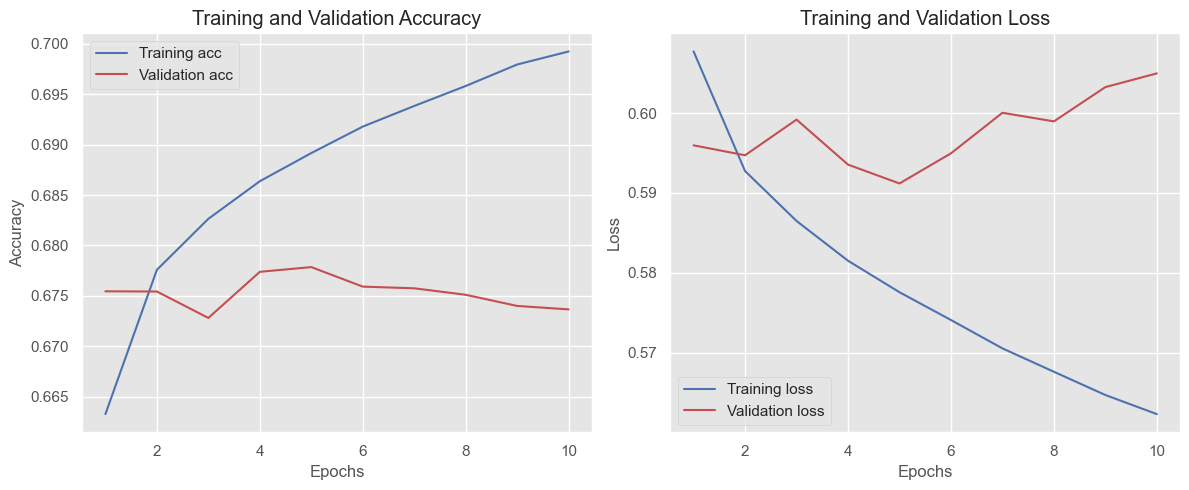

In [35]:
import matplotlib.pyplot as plt


plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()

plot_history(cnn_model.history)

In [37]:

results = cnn_model.evaluate(X_test, y_test, verbose=0)

print(f"Baseline Test Loss: {results[0]:.4f}")
print(f"Baseline Test Accuracy: {results[1]*100:.2f}%")

Baseline Test Loss: 0.6050
Baseline Test Accuracy: 67.37%


10424/10424 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
Classification Report:

              precision    recall  f1-score   support

     Natural       0.65      0.76      0.70    166728
   Sarcastic       0.71      0.58      0.64    166827

    accuracy                           0.67    333555
   macro avg       0.68      0.67      0.67    333555
weighted avg       0.68      0.67      0.67    333555



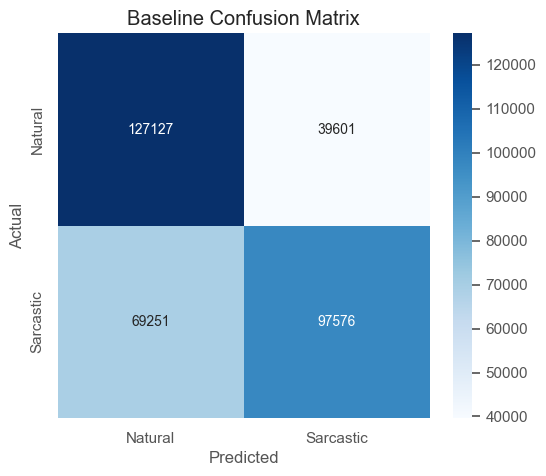

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


y_pred_prob = cnn_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")


print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Natural', 'Sarcastic']))

# visualize with a Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Natural', 'Sarcastic'],
            yticklabels=['Natural', 'Sarcastic'])
plt.title('Baseline Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The primary goal of this modular project is Multi-Task Feature Fusion. Consequently, the output of this notebook is not just the prediction, but the model itself. We save the trained weights so they can be loaded in the Final Output Notebook to generate the "Linguistic Feature Vector" for the ensemble classifier.

In [36]:

cnn_model.save('baseline_linguistic_model.keras')


import pickle
with open('baseline_expert/baseline_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Linguistic Baseline Model and Tokenizer saved successfully.")

Linguistic Baseline Model and Tokenizer saved successfully.


We have successfully engineered a 1D-CNN that captures the literal linguistic cues of sarcasm with an accuracy of approximately $67\%$.